In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

# %pip install CRPS
# %pip install torchgeo

# from pathlib import Path
# import sys
# !sudo apt-get install unzip
# base = Path('/content/drive/MyDrive/ML/2023/conv_strat_dataset')
# sys.path.append(str(base))

# zip_path = base/"test.zip"


# !cp "{zip_path}" .

# !unzip -q test.zip -d "/content"

# !rm test.zip


In [2]:
import torch
import torchvision
import matplotlib.pyplot as plt
import random
import json
from tqdm import tqdm
import os
from os import listdir
from PIL import Image

import torch
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn.functional as F
from torch.optim import Adam
import datetime

# import wandb
# import CRPS.CRPS as pscore



from prec_dataset import RadarPrecipitationSequence
from radar_transforms import radar_transform
from plotting_funcs import show_sequence
from radar_transforms import radar_transform, reverse_transform, conditional_embedding_transform
from fdp import fdp_sample, get_named_beta_schedule
from unet_refr_emb_GPU_0203 import UNet_embedding
from loss import loss_fn
from sampler import sample_plot_image,sample_next_step_pred_CSI
from helper_module import get_random_test_seq, get_CRPS_sequence
from calc_metrics import get_CRPS

config = dict(
    img_out_size=64,
    rgb_grayscale=1,
    sequence_length=8,
    max_prec_val=3.4199221045419974,
    prediction_time_step_ahead=1,
    frames_to_predict=1,
    num_cond_frames=3,
    tot_pred_ahead=4,
    schedule="linear",
    T=1000,

    root_dir=r"/content/",
    validate_on_convective = False,
)

betas = get_named_beta_schedule(
    schedule_name=config["schedule"], num_diffusion_timesteps=config["T"]
)
T = config["T"]
if config["schedule"] == "linear":
    alphas = 1.0 - betas
    alphas_cumprod = torch.cumprod(alphas, axis=0)
    alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
    sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
    sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
    sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)
    posterior_variance = betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod)


device = "cuda" if torch.cuda.is_available() else "cpu"
model_PATH = '/content/drive/MyDrive/ML/results/plots/0503_hightech_unet/2023-03-05_epoch_40'

### LOAD PRE-TRAINED MODELS: 

In [ ]:
model = UNet_embedding(
    rgb_grayscale=config["rgb_grayscale"], num_cond_frames=config["num_cond_frames"], device=device
)
model.load_state_dict(torch.load(model_PATH,map_location=torch.device('cpu')))

model.eval()
model.to(device)

import torch
from torchgeo.models import resnet18, ResNet18_Weights

weights = ResNet18_Weights.SENTINEL2_RGB_MOCO

cond_emb_model = resnet18(weights=weights)
cond_emb_model.eval()
cond_emb_model.to(device)


49


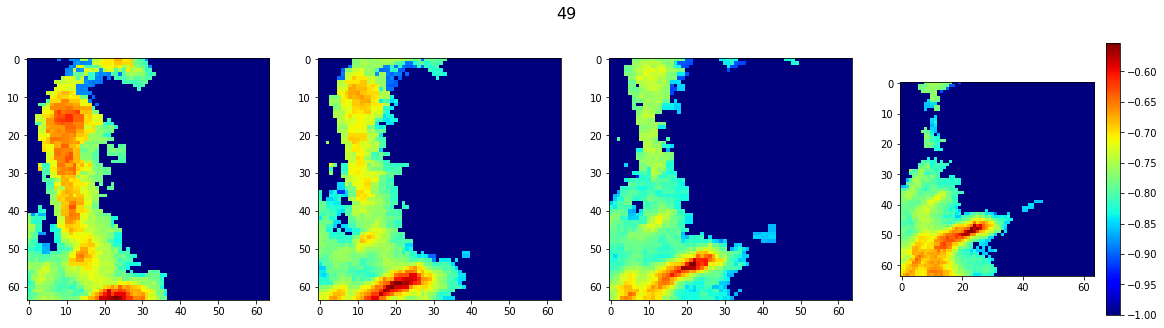

702


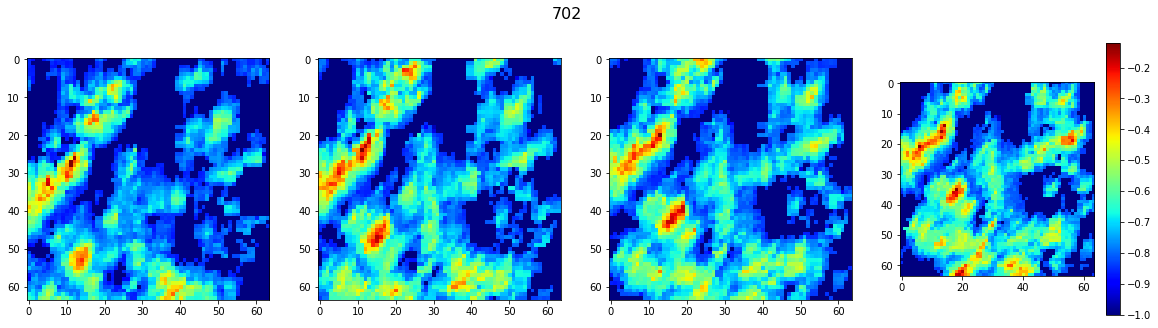

998


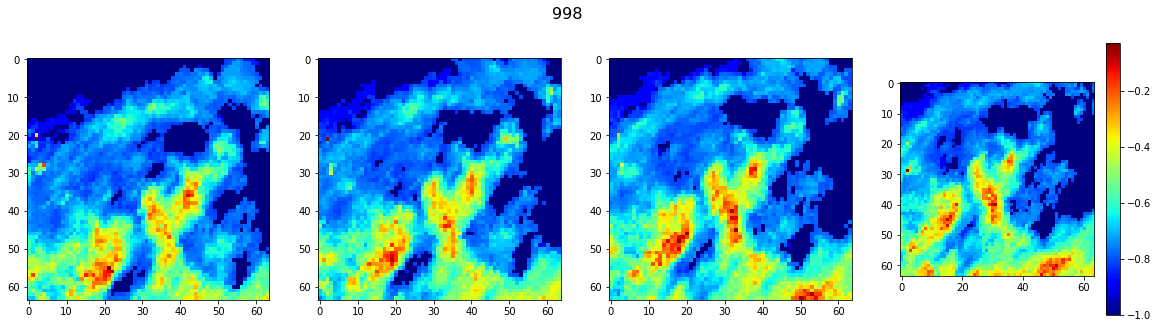

508


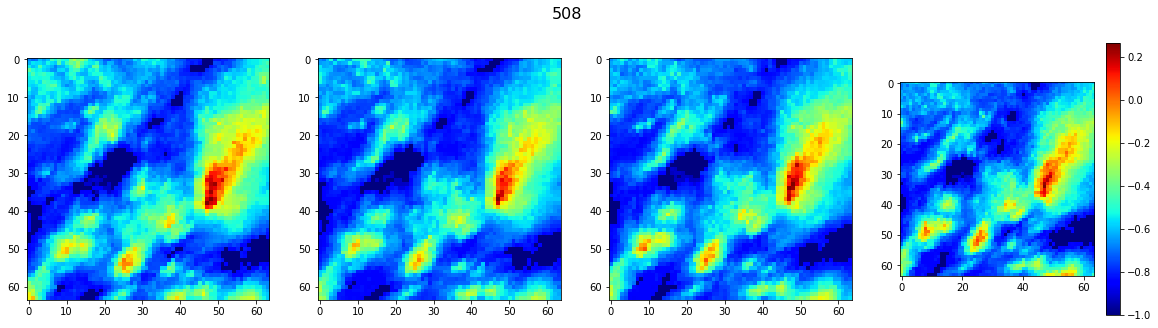

18


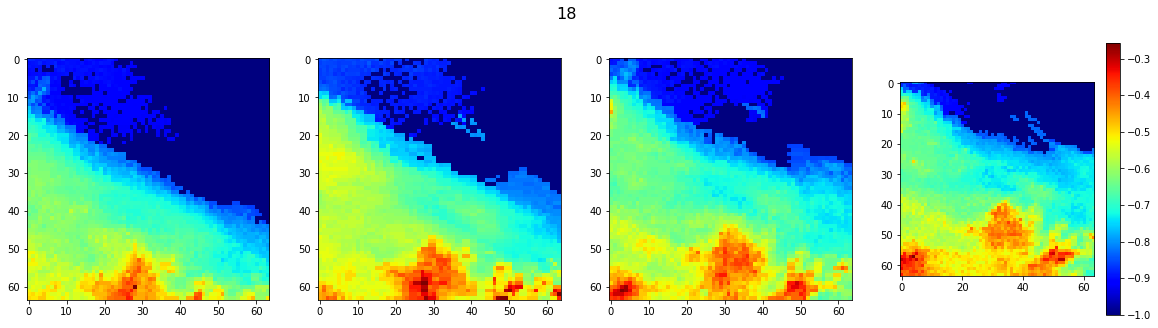

950


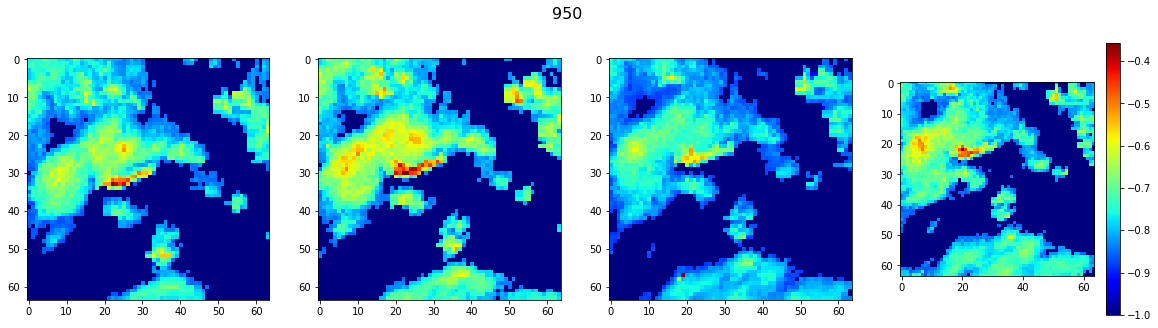

279


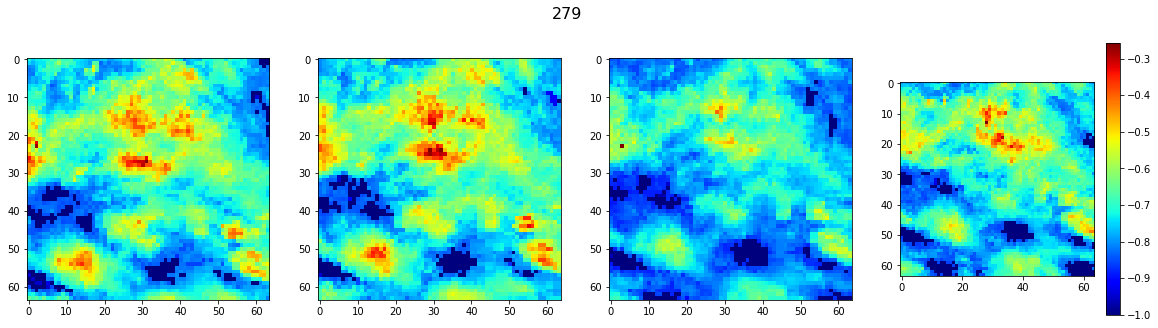

375


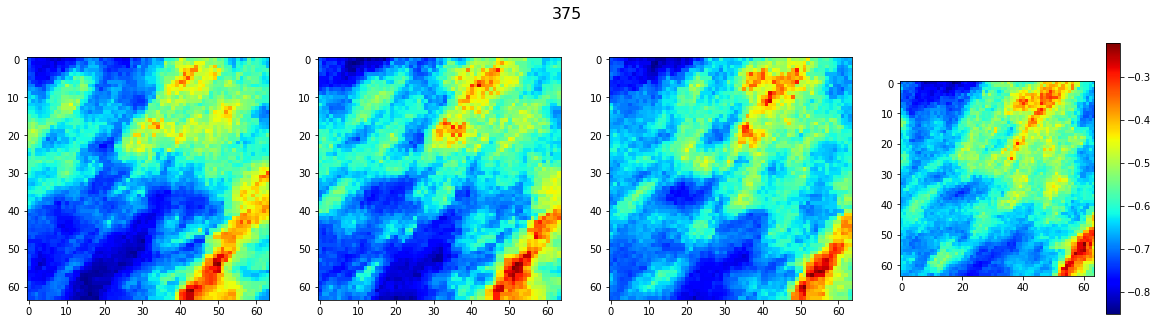

202


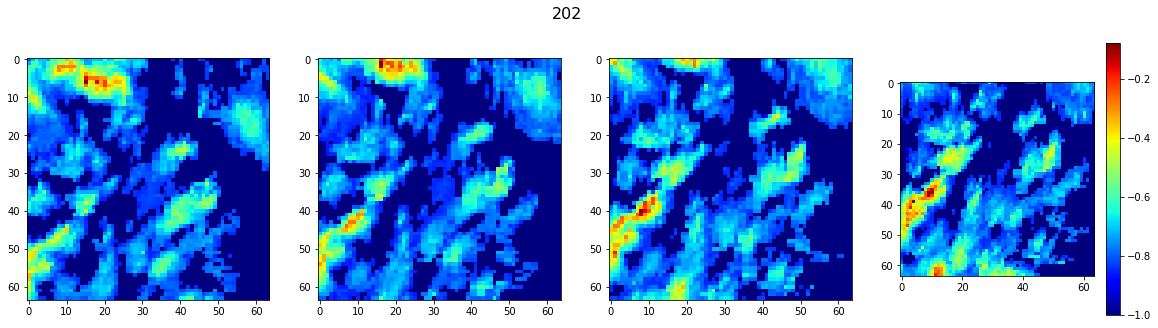

257


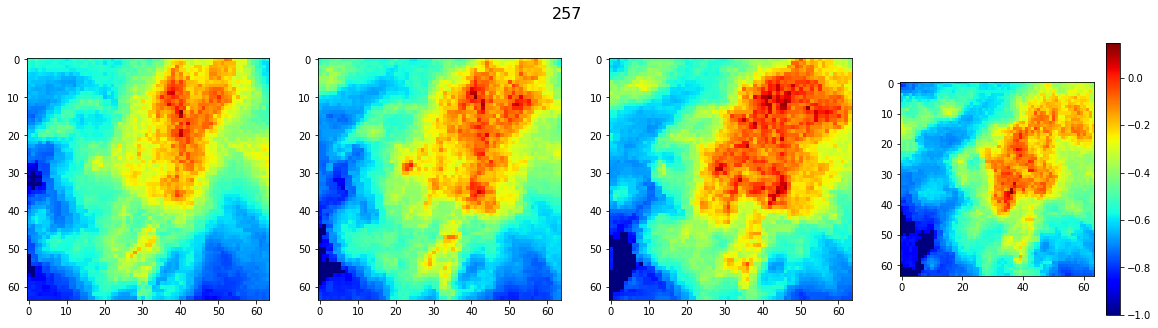

908


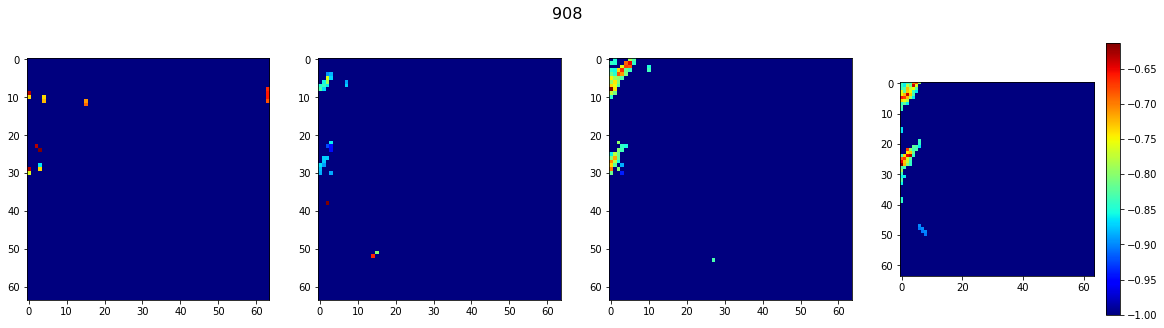

162


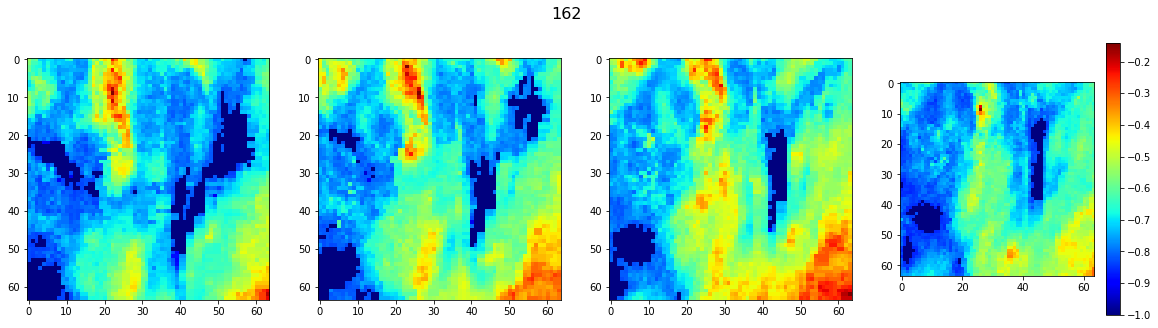

566


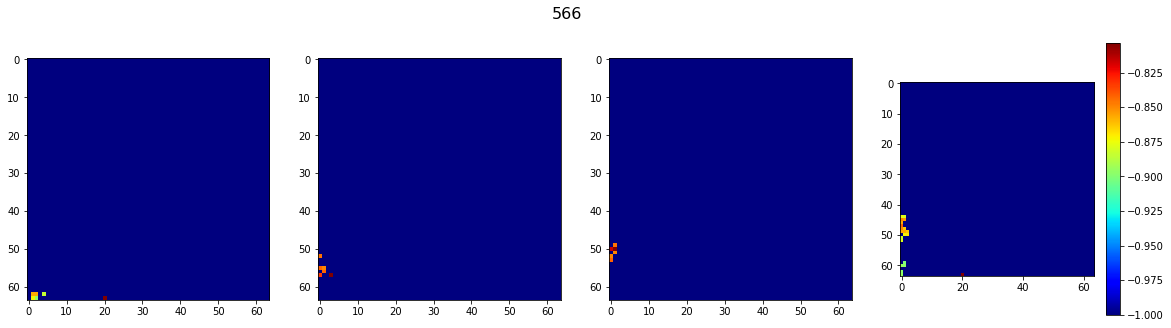

536


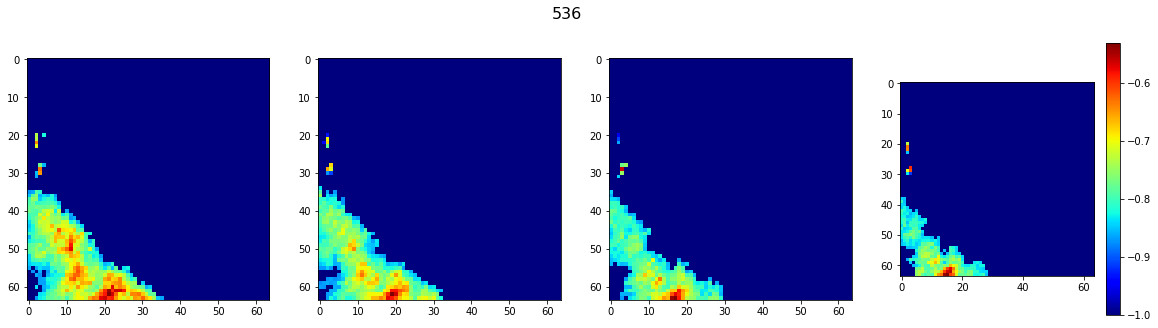

98


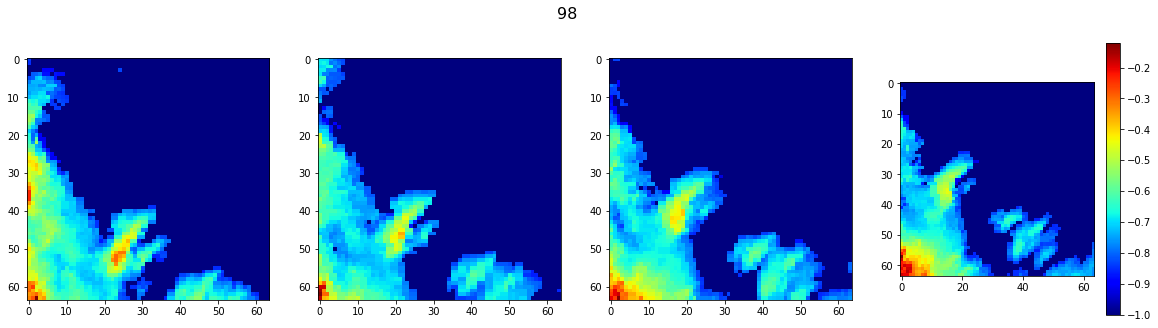

627


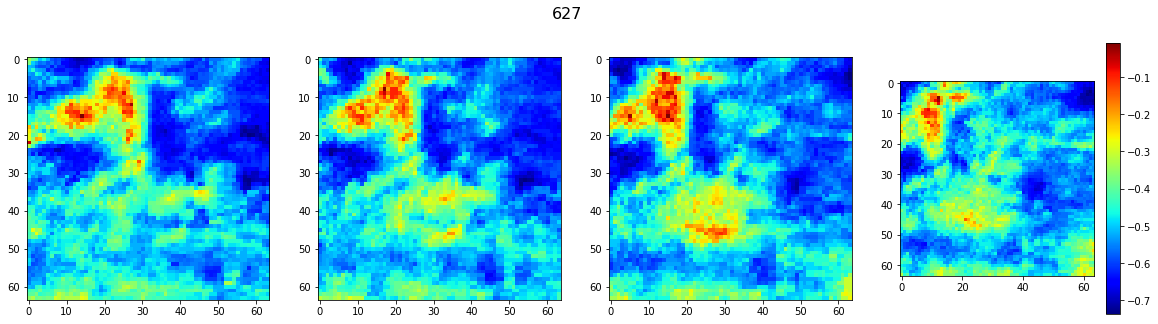

3


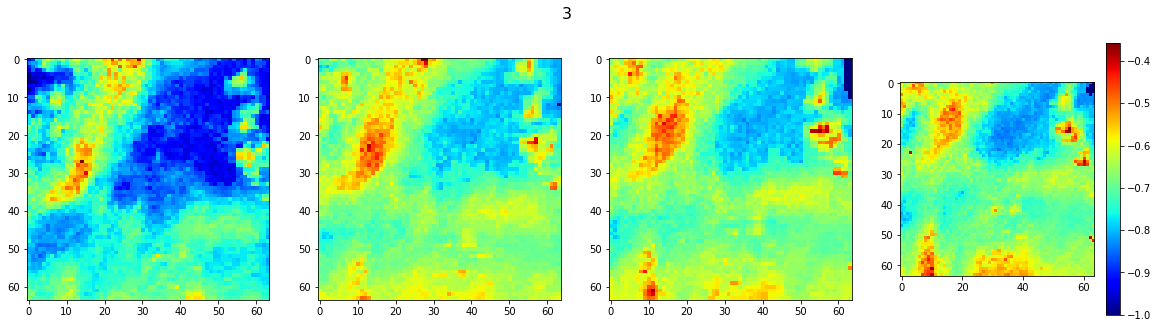

880


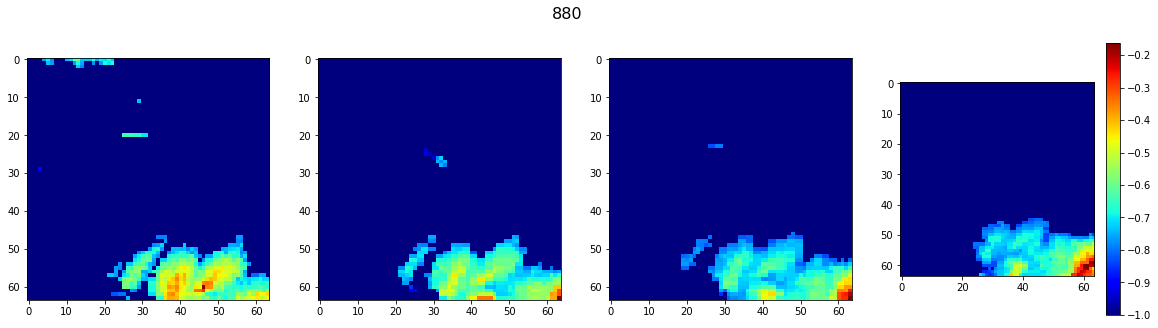

735


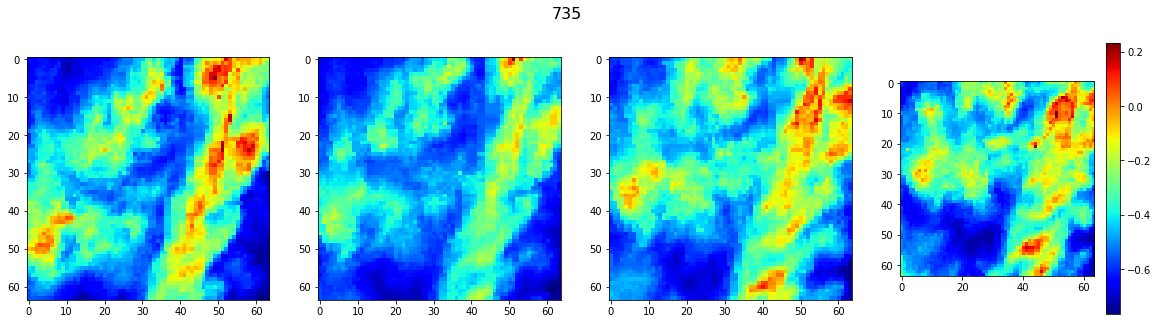

772


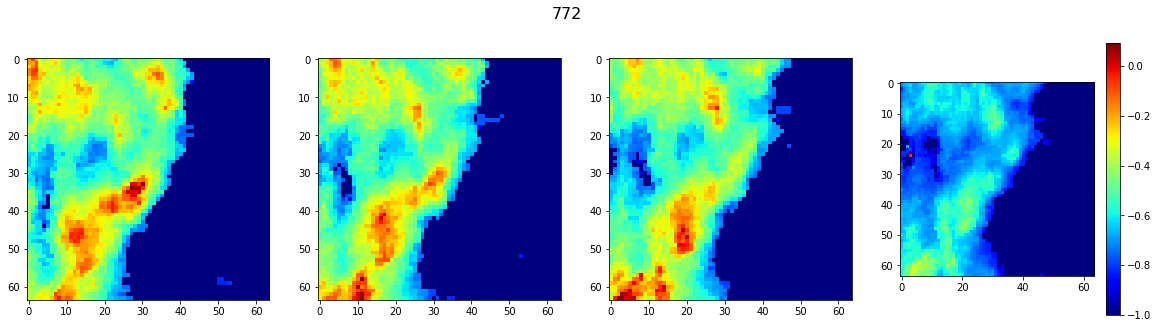

In [52]:
dataset_20min_nowcast = RadarPrecipitationSequence(
    root_dir=config["root_dir"],
    transform=radar_transform(max_prec_val=config["max_prec_val"]),
    emb_transform=conditional_embedding_transform(max_prec_val=config["max_prec_val"]),
    num_cond_frames=config["num_cond_frames"],
    frames_to_predict=config["frames_to_predict"],
    img_out_size=config["img_out_size"],
    prediction_time_step_ahead=config["prediction_time_step_ahead"],
    train_test_val = "test",
    center_crop = True
)



test_loader = DataLoader(
    dataset_20min_nowcast,
    batch_size=6,
    shuffle=False,
    drop_last=True,
)
for i in range(20):
    idx = np.random.randint(low=0, high=1000)
    train_sample = dataset_20min_nowcast.__getitem__(idx)

    seq = train_sample[3]
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))
    fig.suptitle(f'{idx}', fontsize=16)

    ax1 = plt.subplot(141)
    ax1.imshow((seq[0, :, :]), cmap="jet")

    ax2 = plt.subplot(142)
    ax2.imshow((seq[1, :, :]), cmap="jet")

    ax3 = plt.subplot(143)
    ax3.imshow((seq[2, :, :]), cmap="jet")

    ax4 = plt.subplot(144)
    im4 = ax4.imshow((seq[3, :, :]), cmap="jet")
    fig.colorbar(im4)
    plt.show()


#### Metrics:

In [57]:
from calc_metrics import get_nowcast_20_CRPS


sample_size = 5




crps_matrix= torch.zeros((4,4,sample_size))


sample_idx = np.random.randint(0, dataset_20min_nowcast.__len__(), size = sample_size)
print(sample_idx)

preds_csi = torch.empty((sample_size,4 ,64,64))
obs_csi = torch.empty((sample_size,4,64,64))


with torch.no_grad():



    for sample_step,j in enumerate(tqdm((sample_idx))):
        sample = dataset_20min_nowcast.__getitem__(j)

        prev_frames = 3
        img_out_size = config["img_out_size"],
        tot_pred_ahead = config["tot_pred_ahead"]

        pred_seq = torch.zeros((7,224,224)).to(device)
        pred_seq_csi = torch.zeros((4,64,64))
        cond_input = sample[1].to(device)
        observed = sample[3].to(device)
        obs_csi[sample_step,:,:,:] = observed[4:8,:,:]
        
        pred_seq[:prev_frames,:,:] = cond_input[:prev_frames,:,:]  

        # only get LWE data:

        pred_seq = pred_seq[None, :, :, :]


        for i in range(prev_frames,prev_frames+config["tot_pred_ahead"]):
            #get 4 past frames:
            cond_frames = pred_seq[:, i-prev_frames:i, :, :]

            observed_nxt_step = observed[None,i, :, :]

            cond_frames = cond_frames.to(device)
            observed_nxt_step = observed_nxt_step.to(device)
            
            #pred next frame n times and get crps:
            avg_4_crps,avg_16_crps, max_4_crps,max_16_crps = get_nowcast_20_CRPS(
                cond_frames = cond_frames,
                observation = observed_nxt_step, 
                sequence_length = config['sequence_length'],
                max_prec_val = config['max_prec_val'],
                betas = betas,
                rgb_grayscale=1,
                img_out_size=64,
                device=device,
                sqrt_one_minus_alphas_cumprod=sqrt_one_minus_alphas_cumprod,
                sqrt_recip_alphas=sqrt_recip_alphas,
                posterior_variance=posterior_variance,
                model=model,
                numb_of_samples = 3,
                T = 5,
                cond_emb_model = cond_emb_model
            )

            crps_matrix[i-prev_frames, 0, sample_step] = avg_4_crps
            crps_matrix[i-prev_frames, 1, sample_step] = avg_16_crps
            crps_matrix[i-prev_frames, 2, sample_step] = max_4_crps
            crps_matrix[i-prev_frames, 3, sample_step] = max_16_crps

            
            #get next image in sequence;
            pred_next_frame = sample_next_step_pred_CSI(
            cond_frames = cond_frames,
            device = device,
            sqrt_one_minus_alphas_cumprod = sqrt_one_minus_alphas_cumprod,
            sqrt_recip_alphas = sqrt_recip_alphas,
            posterior_variance = posterior_variance,
            model = model,
            T = 20,
            betas = betas,
            rgb_grayscale=1,
            img_out_size=64,
            cond_emb_model=cond_emb_model,
            sample_scheme = False)
            # print(pred_next_frame.max())
            # print(pred_next_frame.min())

            pred_next_frame_interp = F.interpolate(input = pred_next_frame, size=(224), mode="nearest")
            pred_seq[:,i,:,:] = pred_next_frame_interp

            pred_seq_csi[i-prev_frames,:,:] = pred_next_frame


        preds_csi[sample_step,:,:,:] = pred_seq_csi[:,:,:]




[990  73 309 168 228]


100%|██████████| 5/5 [00:29<00:00,  5.95s/it]


### PLOT CRPS:


In [ ]:

time_steps = 4
pool_types = 4
crps_mean  = torch.zeros((pool_types,time_steps))
crps_std  = torch.zeros((pool_types,time_steps))

for time_step in range(4):
    crps_i_min =  crps_matrix[time_step,:,:]
    for pool_type in range(4):

        crps_pool = crps_i_min[pool_type,:]

        mean = crps_pool.mean()
        std = crps_pool.std()
        crps_mean[pool_type,time_step] = mean 
        crps_std[pool_type,time_step] = std 




print(crps_mean[:,0])
print(crps_std[:,0])



fig, axs = plt.subplots(1, 2, figsize=(25, 7))

ax1 = plt.subplot(121)
ticks = np.arange(5, 21, 5)
ax1.errorbar(ticks, crps_mean[:,0],crps_std[:,0],color="m", label='Pooling scale = 4 km')
ax1.errorbar(ticks, crps_mean[:,1],crps_std[:,1],color="skyblue", label='Pooling scale = 16 km')
ax1.set_xticks(ticks)
ax1.set_xlabel('Prediction interval (min)')
ax1.set_ylabel('Avg-pooled CRPS')
ax1.legend()

ax2 = plt.subplot(122)
ax2.errorbar(ticks, crps_mean[:,2],crps_std[:,2],color="m", label='Pooling scale = 4 km')
ax2.errorbar(ticks, crps_mean[:,3],crps_std[:,3],color="skyblue", label='Pooling scale = 16 km')
ax2.set_xticks(ticks)
ax2.set_xlabel('Prediction interval (min)')
ax2.set_ylabel('Max-pooled CRPS')
ax2.legend()
plt.show()




### VISUALIZE 20 MIN FORECAST:

In [ ]:
seq_number = 0

seq1 = preds_csi[0]

seq1 += 1
seq1 /= 2
seq1 *= config['max_prec_val']
seq1 **= 3


observed_seq = dataset_20min_nowcast.__getitem__(sample_idx[seq_number])
lwe = observed_seq[3]
lwe = lwe[config['num_cond_frames']:,:,:]

lwe += 1
lwe /= 2
lwe *= config['max_prec_val']
lwe **= 3




stamp_string = observed_seq[4]
time_stamp = stamp_string.split(".")[0]
time_stamp = int(time_stamp)
stamp_arr = [time_stamp + (i * 60 * 5) for i in range(8)]

timestamp_arr = [
datetime.datetime.fromtimestamp(stamp).strftime("%Y-%m-%d %H:%M:%S")
for stamp in stamp_arr
]
timestamp_arr = timestamp_arr[config['num_cond_frames']:]




fig, axs = plt.subplots(1, 4, figsize=(20, 5))
fig.suptitle('Model predictions', fontsize=16)

ax1 = plt.subplot(141)
ax1.imshow((seq1[0, :, :]), cmap="jet")
ax1.set_title(f"{timestamp_arr[0]}")

ax2 = plt.subplot(142)
ax2.imshow((seq1[1, :, :]), cmap="jet")
ax2.set_title(f"{timestamp_arr[1]}")

ax3 = plt.subplot(143)
ax3.imshow((seq1[2, :, :]), cmap="jet")
ax3.set_title(f"{timestamp_arr[2]}")

ax4 = plt.subplot(144)
im4 = ax4.imshow((seq1[3, :, :]), cmap="jet")
ax4.set_title(f"{timestamp_arr[3]}")
fig.colorbar(im4)
plt.show()


fig, axs = plt.subplots(1, 4, figsize=(20, 5))
fig.suptitle('Observed Radar Precipitation', fontsize=16)

ax1 = plt.subplot(141)
ax1.imshow((lwe[0, :, :]), cmap="jet")
ax1.set_title(f"{timestamp_arr[0]}")

ax2 = plt.subplot(142)
ax2.imshow((lwe[1, :, :]), cmap="jet")
ax2.set_title(f"{timestamp_arr[1]}")

ax3 = plt.subplot(143)
ax3.imshow((lwe[2, :, :]), cmap="jet")
ax3.set_title(f"{timestamp_arr[2]}")

ax4 = plt.subplot(144)
im4 = ax4.imshow((lwe[3, :, :]), cmap="jet")
ax4.set_title(f"{timestamp_arr[3]}")
fig.colorbar(im4)
plt.show()




### Get CSI metrics:


In [35]:
from metrics import csi

#TRANSFORM VALUES TO PRECIPIATION VALS:

pred_copy = preds_csi
pred_copy += 1
pred_copy /= 2
pred_copy *= config['max_prec_val']
pred_copy **= 3

obs_copy = obs_csi
obs_copy += 1
obs_copy /= 2
obs_copy *= config['max_prec_val']
obs_copy **= 3



time_steps = 4

csi_0_01 = torch.zeros((sample_size, time_steps))
csi_2 = torch.zeros((sample_size, time_steps))
csi_10 = torch.zeros((sample_size, time_steps))


for smpl in range(sample_size):
    pred = pred_copy[smpl,:,:,:]
    obs = obs_copy[smpl,:,:,:]

    for i in range(time_steps):
        csi_0_01[smpl,i] = csi(predictions=pred[i], observed = obs[i], t=0.01)
        csi_2[smpl,i] = csi(predictions=pred[i], observed = obs[i], t=2)
        csi_10[smpl,i] = csi(predictions=pred[i], observed = obs[i], t=10)



In [ ]:


def plot_csi(time_steps, csi_tensor):
    csi_mean = []
    csi_std = []

    for i in range(time_steps):
        csi_ = csi_tensor[:,i]

        csi_mean.append(csi_.mean())
        csi_std.append(csi_.std())
    return csi_mean, csi_std

csi_05_mean, csi_05_std = plot_csi(4,csi_0_01)
csi_2_mean, csi_2_std = plot_csi(4,csi_2)
csi_10_mean, csi_10_std = plot_csi(4,csi_10)

fig, axs = plt.subplots(1, 1, figsize=(15, 5))
print(csi_05_std)

ax1 = plt.subplot(111)
ticks = np.arange(5, 21, 5)
ax1.errorbar(ticks, csi_05_mean,csi_05_std,color="m", label='Threshold: 0.01 mm/hr')
ax1.errorbar(ticks, csi_2_mean,csi_2_std,color="khaki", label='Threshold: 2 mm/hr')
ax1.errorbar(ticks, csi_10_mean,csi_10_std,color="skyblue", label='Threshold: 10 mm/hr')

ax1.set_xticks(ticks)
ax1.set_ylim([0,1.1])
ax1.set_xlabel('Prediction interval (min)')
ax1.set_ylabel('CSI')
ax1.legend()

# ax1.legend()

# ax2 = plt.subplot(132)
# ticks = np.arange(5, 21, 5)
# ax2.errorbar(ticks, csi_2_mean,csi_2_std, marker='^', label='Threshold: 2 mm/hr')
# ax2.set_xticks(ticks)
# ax2.set_ylim([0,1.1])
# ax2.set_xlabel('Prediction interval (min)')
# ax2.set_ylabel('CSI')
# ax2.legend()

# ax3 = plt.subplot(133)
# ticks = np.arange(5, 21, 5)
# ax3.set_xticks(ticks)
# ax3.set_ylim([0,1.1])
# ax3.set_xlabel('Prediction interval (min)')
# ax3.set_ylabel('CSI')
# ax3.legend()




In [ ]:

                    
                    

        #     fig, axs = plt.subplots(1, 1, figsize=(30, 5))
            
        #     epoch_list = np.arange(0, len(validation_loss_list))
        #     ax1 = plt.subplot(111)
        #     ax1.plot(epoch_list, validation_loss_list, label='Validation loss')
        #     ax1.plot(epoch_list, train_loss_list, label='Train loss')
        #     ax1.set_title(f"MSE")
        #     ax1.legend()
            
        #     ax2 = plt.subplot(132)
        #     crps_epochs = np.arange(0, len(avg_4_crps_mean))
        #     labels = crps_epochs*3
        #     labels = labels.astype('str')

        #     ax2.errorbar(crps_epochs, avg_4_crps_mean,avg_4_crps_std, marker='^', label='4-km aggregations')
        #     ax2.errorbar(crps_epochs, avg_16_crps_mean,avg_16_crps_std, marker='*', label='16-km aggregations')
        #     ax2.set_yscale('log')
        #     ax2.set_title(f"Pooled CRPS using the average rain rate")
        #     ax2.legend()

        #     ax3 = plt.subplot(133)
        #     ax3.errorbar(crps_epochs, max_4_crps_mean,max_4_crps_std, marker='^', label='4-km aggregations')
        #     ax3.errorbar(crps_epochs, max_16_crps_mean,max_16_crps_std, marker='^', label='16-km aggregations')
        #     ax3.set_title(f"Pooled CRPS using the maximum rain rate")
        #     ax3.set_yscale('log')
        #     ax3.legend()

        #     folder_path = config["plot_folder"]
        #     fig.savefig(f"{folder_path}/MSE_epoch_{epoch}.png")

        #     plt.show()


        # if epoch % 5 == 0:

        #     if config["validate_on_convective"]:
        #         pass

        #     seq_list_plot = get_CRPS_sequence(dataset=dataset_radar_sequence_val_CRPS, idx_list= crps_idx_list)

        #     sample_plot_image(
        #         test_list=seq_list_plot,
        #         rgb_grayscale=config["rgb_grayscale"],
        #         img_out_size=config["img_out_size"],
        #         sequence_length=config["sequence_length"],
        #         device=device,
        #         sqrt_one_minus_alphas_cumprod=sqrt_one_minus_alphas_cumprod,
        #         sqrt_recip_alphas=sqrt_recip_alphas,
        #         posterior_variance=posterior_variance,
        #         model=model,
        #         T=config["T"],
        #         pred_ahead= config["prediction_time_step_ahead"],
        #         numb_cond = config["num_cond_frames"],
        #         betas = betas,
        #         max_prec_val = config["max_prec_val"],
        #         epoch = epoch,
        #         out_folder = config["plot_folder"]
        #         )
        #set model back to training mode: 

#### Get (ONE) 20 minute nowcast: 

In [ ]:
# # #load seq:
# # idx_list = [0,1]
# # seq_list = get_20min_forecast_sequence(dataset=dataset_20min_nowcast, idx_list= idx_list)
# #load seq:
# from calc_metrics import get_nowcast_20_CRPS

# sequence_idx = 441
# test_sample = dataset_20min_nowcast.__getitem__(sequence_idx)

# stamp_string = test_sample[3]
# time_stamp = stamp_string.split(".")[0]
# time_stamp = int(time_stamp)
# stamp_arr = [time_stamp + (i * 60 * 5) for i in range(8)]

# timestamp_arr = [
# datetime.datetime.fromtimestamp(stamp).strftime("%Y-%m-%d %H:%M:%S")
# for stamp in stamp_arr
# ]

# prev_frames = 3
# img_out_size = config["img_out_size"],
# tot_pred_ahead = config["tot_pred_ahead"]

# pred_seq = torch.zeros((8,224,224))
# cond_input = test_sample[1]
# pred_seq[:prev_frames,:,:] = cond_input[:prev_frames,:,:]  

# # only get LWE data:

# pred_seq = pred_seq[None, :, :, :]


# avg4_list =[]
# avg16_list =[]
# max4_list =[]
# max16_list =[]

# for i in range(prev_frames,prev_frames+config["tot_pred_ahead"]):
#     #get 4 past frames:
#     cond_frames = pred_seq[:, i-prev_frames:i, :, :]

#     observed_nxt_step = lwe_data[None,i, :, :]

#     cond_frames = cond_frames.to(device)
    
#     #pred next frame n times and get crps:
#     avg_4_crps,avg_16_crps, max_4_crps,max_16_crps = get_nowcast_20_CRPS(
#         cond_frames = cond_frames,
#         observation = observed_nxt_step, 
#         sequence_length = config['sequence_length'],
#         max_prec_val = config['max_prec_val'],
#         betas = betas,
#         rgb_grayscale=1,
#         img_out_size=64,
#         device=device,
#         sqrt_one_minus_alphas_cumprod=sqrt_one_minus_alphas_cumprod,
#         sqrt_recip_alphas=sqrt_recip_alphas,
#         posterior_variance=posterior_variance,
#         model=model,
#         numb_of_samples = 3,
#         T = config['T']
#     )
#     avg4_list.append(avg_4_crps)
#     avg16_list.append(avg_16_crps)
#     max4_list.append(max_4_crps)
#     max16_list.append(max_16_crps)

#     pred_next_frame = sample_next_step_pred(
#     cond_frames = cond_frames,
#     device = device,
#     sqrt_one_minus_alphas_cumprod = sqrt_one_minus_alphas_cumprod,
#     sqrt_recip_alphas = sqrt_recip_alphas,
#     posterior_variance = posterior_variance,
#     model = model,
#     T = 300,
#     betas = betas,
#     rgb_grayscale=1,
#     img_out_size=64)
#     # add to sequence
#     pred_seq[:,i,:,:] = pred_next_frame

    


# #process data to get prec. vals
# pred_seq += 1
# pred_seq /= 2
# pred_seq *= config["max_prec_val"]
# pred_seq **= 3
# max_pred_seq = torch.max(pred_seq)
# print(f'max pred seq val: {max_pred_seq}')
# # lwe_data  += 1
# # lwe_data  /= 2
# # lwe_data  *= config["max_prec_val"]
# # lwe_data  **= 3
# max_data_val = torch.max(lwe_data )
# print(f'max max_data_val: {max_data_val}')

# max_val = max(max_pred_seq, max_data_val)
# print(max_val)



# fig, axs = plt.subplots(1, 4, figsize=(20, 5))
# fig.suptitle('Model input', fontsize=16)

# ax1 = plt.subplot(141)
# ax1.imshow((pred_seq[0, 0, :, :]), cmap="jet", vmin=0, vmax=max_val)
# ax1.set_title(f"{timestamp_arr[0]}")

# ax2 = plt.subplot(142)
# ax2.imshow((pred_seq[0, 1, :, :]), cmap="jet", vmin=0, vmax=max_val)
# ax2.set_title(f"{timestamp_arr[1]}")

# ax3 = plt.subplot(143)
# ax3.imshow((pred_seq[0, 2, :, :]), cmap="jet", vmin=0, vmax=max_val)
# ax3.set_title(f"{timestamp_arr[2]}")

# ax4 = plt.subplot(144)
# im4 = ax4.imshow((pred_seq[0, 3, :, :]), cmap="jet", vmin=0, vmax=max_val)
# ax4.set_title(f"{timestamp_arr[3]}")
# fig.colorbar(im4)
# plt.show()

# fig, axs = plt.subplots(1, 4, figsize=(15, 5))
# fig.suptitle('Model prediction', fontsize=16)

# ax5 = plt.subplot(141)
# ax5.imshow((pred_seq[0, 4, :, :]), cmap="jet", vmin=0, vmax=max_val)
# ax5.set_title(f"{timestamp_arr[4]}")

# ax6 = plt.subplot(142)
# ax6.imshow((pred_seq[0, 5, :, :]), cmap="jet", vmin=0, vmax=max_val)
# ax6.set_title(f"{timestamp_arr[5]}")

# ax7 = plt.subplot(143)
# ax7.imshow((pred_seq[0, 6, :, :]), cmap="jet", vmin=0, vmax=max_val)
# ax7.set_title(f"{timestamp_arr[6]}")

# ax8 = plt.subplot(144)
# im8 = ax8.imshow((pred_seq[0, 7, :, :]), cmap="jet", vmin=0, vmax=max_val)
# ax8.set_title(f"{timestamp_arr[7]}")
# fig.colorbar(im8)

# plt.show()


# fig, axs = plt.subplots(1, 4, figsize=(15, 5))
# fig.suptitle('Ground truth', fontsize=16)

# ax15 = plt.subplot(141)
# ax15.imshow((lwe_data[4, :, :]), cmap="jet", vmin=0, vmax=max_val)
# ax15.set_title(f"{timestamp_arr[4]}")

# ax16 = plt.subplot(142)
# ax16.imshow((lwe_data[5, :, :]), cmap="jet", vmin=0, vmax=max_val)
# ax16.set_title(f"{timestamp_arr[5]}")

# ax17 = plt.subplot(143)
# ax17.imshow((lwe_data[6, :, :]), cmap="jet", vmin=0, vmax=max_val)
# ax17.set_title(f"{timestamp_arr[6]}")

# ax18 = plt.subplot(144)
# im18 = ax18.imshow((lwe_data[7, :, :]), cmap="jet", vmin=0, vmax=max_val)
# ax18.set_title(f"{timestamp_arr[7]}")
# fig.colorbar(im18)


# plt.show()

# fig, axs = plt.subplots(1, 3, figsize=(15, 5))
# fig.suptitle('Metrics', fontsize=16)

# preds = pred_seq[0,4:,:,:]
# obs = lwe_data[4:,:,:]

# x_time = [5,10,15,20]
# csi_2 = [csi(predictions=preds[i], observed = obs[i], t=0.5) for i in range(4)]
# csi_5 = [csi(predictions=preds[i], observed = obs[i], t=2) for i in range(4)]
# csi_10 = [csi(predictions=preds[i], observed = obs[i], t=10) for i in range(4)]

# ax25 = plt.subplot(131)
# ax25.plot(x_time, csi_2, marker='^', label='2 mm/hr')
# ax25.plot(x_time, csi_5, marker='^', label='5 mm/hr')
# ax25.plot(x_time, csi_10, marker='^', label='10 mm/hr')
# ax25.legend()
# ax25.set_title(f"CSI")



# ax21 = plt.subplot(132)
# ax21.plot(x_time, avg4_list, marker='^', label='4-km aggregations')
# ax21.plot(x_time, avg16_list, marker='^', label='16-km aggregations')
# ax21.legend()
# ax21.set_title(f"CRPS, Average pooling")


# ax22 = plt.subplot(133)
# ax22.plot(x_time, max4_list, marker='^', label='4-km aggregations')
# ax22.plot(x_time, max16_list, marker='^', label='16-km aggregations')
# ax22.legend()
# ax22.set_title(f"CRPS, Max pooling")


# plt.show()


# print(f'csi2: {csi_2}')
# print(f'csi5: {csi_5}')
# print(f'csi10: {csi_10}')